In [1]:
from matplotlib.axis import YAxis
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
import math
import json

In [2]:
#Import Scraped rib.gg Data
df = pd.read_csv("../Amer-VCT-Spring2023/data/EventEssentials+Players.csv")

In [3]:
#Set Attack Team Win as target variable
df['ATKWin'] = 0
for i in range(0, len(df)):

    if(df.loc[i, 'attackingTeamNumber'] == df.loc[i, 'winningTeamNumber']):
        df.loc[i, 'ATKWin'] = 1

In [4]:
#Seperate Independent and Dependent Variables
indVars = df.drop(columns=['roundId_x', 'attackingTeamNumber', 'winningTeamNumber','ATKWin', 'playerId', 'assistants', 'victimId'])
depVar = df[['matchId_y', 'ATKWin']]

In [5]:
start_test_matchId = 112510

#Train on group stage
X_train = indVars[indVars['matchId_y'] < start_test_matchId].drop(columns=['matchId_y'])
Y_train = depVar[depVar['matchId_y'] < start_test_matchId].drop(columns=['matchId_y'])

#Test on single match
X_test = indVars[indVars['matchId_y'] == start_test_matchId].drop(columns=['matchId_y'])
y_test = depVar[depVar['matchId_y'] == start_test_matchId].drop(columns=['matchId_y'])

In [6]:
#do Logisistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, Y_train.values.ravel())

LogisticRegression()

In [7]:
#Team 1 vs Team 2 Match
print(df[df['matchId_y'] == start_test_matchId])

      matchId_y  roundId_x  attackingTeamNumber  roundTime  ATKAlive  \
5237     112510    1759256                    2     100000         5   
5238     112510    1759256                    2      80039         5   
5239     112510    1759256                    2          0         5   
5240     112510    1759256                    2      -7518         5   
5241     112510    1759256                    2     -11745         5   
...         ...        ...                  ...        ...       ...   
5378     112510    1759273                    1      97589         4   
5379     112510    1759273                    1      60606         3   
5380     112510    1759273                    1      52250         2   
5381     112510    1759273                    1      37558         1   
5382     112510    1759273                    1      31625         0   

      DEFAlive  ATKLoadoutValue  DEFLoadoutValue  winningTeamNumber  playerId  \
5237         5      3800.000000      3500.000000      

In [8]:
#Transform Bomb Time from (100000 to -450000) -> (0 to 1)
def NormalizeData(data):
    # return (data - np.max(data)) / (np.min(data) - np.max(data))
    return (data - np.max(data)) / (-45000 - np.max(data))

In [9]:
#Set X-axis for graph (round + event time)
xAx = df[df['matchId_y'] == start_test_matchId]['roundId_x']-df[df['matchId_y'] == start_test_matchId]['roundId_x'][df[df['matchId_y'] == start_test_matchId].index[0]] +1 + NormalizeData(df[df['matchId_y'] == start_test_matchId]['roundTime'])


In [10]:
#Find index of round 13 (halftime)
halftime = xAx.loc[xAx==13].index[0] - xAx.loc[xAx==1].index[0]
#print(xAx.head(60))

In [11]:
#Get probability of [ATKWin=0, ATKWin=1]
y_pred=logreg.predict_proba(X_test)
print(y_pred)

[[0.58837255 0.41162745]
 [0.51428617 0.48571383]
 [0.41394217 0.58605783]
 [0.3664445  0.6335555 ]
 [0.30888645 0.69111355]
 [0.35268096 0.64731904]
 [0.31594492 0.68405508]
 [0.29085389 0.70914611]
 [0.04966883 0.95033117]
 [0.11363837 0.88636163]
 [0.1021499  0.8978501 ]
 [0.1020808  0.8979192 ]
 [0.23385991 0.76614009]
 [0.21978748 0.78021252]
 [0.21854013 0.78145987]
 [0.1643226  0.8356774 ]
 [0.3387534  0.6612466 ]
 [0.59233959 0.40766041]
 [0.56284396 0.43715604]
 [0.79102606 0.20897394]
 [0.91660923 0.08339077]
 [0.94393293 0.05606707]
 [0.96221056 0.03778944]
 [0.98227244 0.01772756]
 [0.98881785 0.01118215]
 [0.53851698 0.46148302]
 [0.29458953 0.70541047]
 [0.11078308 0.88921692]
 [0.04241347 0.95758653]
 [0.03113703 0.96886297]
 [0.47911995 0.52088005]
 [0.7617655  0.2382345 ]
 [0.86258581 0.13741419]
 [0.95489322 0.04510678]
 [0.98615484 0.01384516]
 [0.96204613 0.03795387]
 [0.90041397 0.09958603]
 [0.89048817 0.10951183]
 [0.95966584 0.04033416]
 [0.95723997 0.04276003]


In [12]:
#Get probabilities for home team
if(df[df['matchId_y'] == start_test_matchId].iloc[0]['attackingTeamNumber'] == 1):
    firstHalf = [item[1] for item in y_pred[:halftime]]
    secHalf = [item[0] for item in y_pred[halftime:]]

else:
    firstHalf = [item[0] for item in y_pred[:halftime]]
    secHalf = [item[1] for item in y_pred[halftime:]]

In [13]:
#Sey y-axis for graph
yAx = firstHalf + secHalf
#print(yAx)

In [14]:
#Get final round number
final = math.ceil(xAx.iloc[-1])

In [20]:
#Import match data (from rib.gg discord bot)
matches = pd.read_csv("../Amer-VCT-Spring2023/data/AllMatches.csv")

#Get team names
team1 = matches.loc[matches["Match Id"] == start_test_matchId]["Team 1 Name"].iloc[0]
team2 = matches.loc[matches["Match Id"] == start_test_matchId]["Team 2 Name"].iloc[0]

print(team1)
print(team2)

Leviatán
FURIA


Leviatán vs FURIA


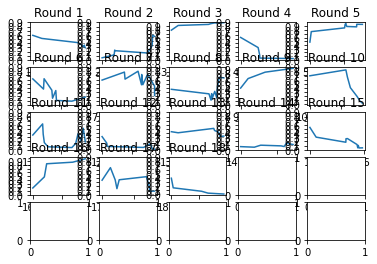

In [27]:
%matplotlib inline

#Set up enough plots for each round
figure, axis = plt.subplots(5, 5)

# Plot x, y for each round graph
round = 1
for i in range(5):
    for j in range(5):
        
        if(round!=final-1):
            axis[i, j].plot(xAx.loc[xAx.loc[xAx==round].index[0]:xAx.loc[xAx==round+1].index[0]-1], yAx[xAx.loc[xAx==round].index[0]-xAx.loc[xAx==1].index[0]:xAx.loc[xAx==round+1].index[0]-xAx.loc[xAx==1].index[0]])
            axis[i, j].set_title("Round " + str(round))  
            # axis[i, j].set_xticks(xAx.loc[xAx.loc[xAx==round].index[0]:xAx.loc[xAx==round+1].index[0]-1])
        else:
            axis[i, j].plot(xAx.loc[xAx.loc[xAx==round].index[0]:], yAx[xAx.loc[xAx==round].index[0]-xAx.loc[xAx==1].index[0]:])
            axis[i, j].set_title("Round " + str(round))
            # axis[i, j].set_xticks(xAx.loc[xAx.loc[xAx==round].index[0]:])

        # axis[i, j].ylim(0, 1) 
        axis[i, j].set_yticks(np.arange(0, 1, step=0.1)) 
        
        round += 1 

        if(round == final):
            break

    if(round == final):
        break
    
# plt.plot(xAx, yAx)
# plt.xlabel('Round')
# plt.ylabel('Win Prob')
# plt.title(team1 + " vs " + team2)

print(team1 + " vs " + team2)
plt.show()